# Importing Libraries and downloading dataset

In [1]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score,train_test_split,cross_validate
from sklearn.metrics import accuracy_score,root_mean_squared_error,r2_score,mean_absolute_error,mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2, convert_continent_code_to_continent_name

In [2]:
def info(df):
    num_instances = df.shape[0]

    num_countries = df["Country"].nunique()
    un_countries = df["Country"].unique()

    num_years = df["Year"].nunique()
    un_years = df["Year"].unique()

    country_counts = df["Country"].value_counts()

    instances_per_year_country = df.groupby(["Country", "Year"]).size().reset_index(name="Instances")

    print(f"1. Total number of instances (rows) in the dataset: {num_instances}")
    print(f"2. Number of different countries: {num_countries}")
    print(un_countries)
    print(f"\n3. Number of different years: {num_years}")
    print(un_years)
    print(f"\n4. Number of instances for each country:")
    print(country_counts)
    print(f"\n5. Number of instances per year per country:")
    print(instances_per_year_country)


path = kagglehub.dataset_download("kumarajarshi/life-expectancy-who")
print("Path to dataset files:", path)
data_path = f"{path}/Life Expectancy Data.csv"
df = pd.read_csv(data_path)
df.columns = df.columns.str.strip()

%matplotlib inline

sns.set_theme(style="whitegrid")

info(df)

Path to dataset files: /home/vitor/.cache/kagglehub/datasets/kumarajarshi/life-expectancy-who/versions/1
1. Total number of instances (rows) in the dataset: 2938
2. Number of different countries: 193
['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Antigua and Barbuda'
 'Argentina' 'Armenia' 'Australia' 'Austria' 'Azerbaijan' 'Bahamas'
 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin'
 'Bhutan' 'Bolivia (Plurinational State of)' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Brunei Darussalam' 'Bulgaria' 'Burkina Faso'
 'Burundi' "Côte d'Ivoire" 'Cabo Verde' 'Cambodia' 'Cameroon' 'Canada'
 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia' 'Comoros'
 'Congo' 'Cook Islands' 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus' 'Czechia'
 "Democratic People's Republic of Korea"
 'Democratic Republic of the Congo' 'Denmark' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Estonia' 'Ethiopia' 'Fiji' 'Finland' 'France' 

In [3]:
num_col=[]
cat_col=[]
for col in df.columns:
    if df[col].dtype=='object':
        cat_col.append(col)
    else:
        num_col.append(col) 
print(cat_col)
print(num_col)
print(len(cat_col)+len(num_col))        

['Country', 'Status']
['Year', 'Life expectancy', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling']
22


# Preprocessing

### Function to map country to the corresponding continent

### Primeira divisão treino/teste

### Separar features e target

### Definir colunas para preprocessamento

### Mapeando países para continentes

In [4]:
def map_country2continent(cname:str):
  try:
    code = country_alpha2_to_continent_code(country_name_to_country_alpha2(cname))
    continent = convert_continent_code_to_continent_name(code)
    return continent
  except Exception as e:
    if str(e) == '"Invalid Country Alpha-2 code: \'TL\'"':
        continent = 'Asia'
        return continent

df['Country'].replace('Republic of Korea', 'South Korea', inplace=True)
df['Continent'] = df['Country'].apply(map_country2continent)
df.drop(columns=['Country'], inplace=True)

df['Continent'].unique()

/tmp/ipykernel_39419/4160891881.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Country'].replace('Republic of Korea', 'South Korea', inplace=True)


array(['Asia', 'Europe', 'Africa', 'North America', 'South America',
       'Oceania', None], dtype=object)

### Separação dos dados

In [5]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [6]:
X_train = df_train.drop(columns=['Life expectancy'])
y_train = df_train['Life expectancy']
X_test = df_test.drop(columns=['Life expectancy'])
y_test = df_test['Life expectancy']

In [7]:
num_attribs = df_train[num_col].drop(columns=['Year', 'Life expectancy']).columns
cat_attribs = df_train[['Continent', 'Status']].columns

### Criar preprocessadores

In [8]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot_encoder', OneHotEncoder(sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

In [9]:
print("Numeric attributes:", num_attribs)
print("Categorical attributes:", cat_attribs)
print("Columns in X_train:", X_train.columns)

Numeric attributes: Index(['Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure',
       'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio',
       'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population',
       'thinness  1-19 years', 'thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')
Categorical attributes: Index(['Continent', 'Status'], dtype='object')
Columns in X_train: Index(['Year', 'Status', 'Adult Mortality', 'infant deaths', 'Alcohol',
       'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI',
       'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria',
       'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling',
       'Continent'],
      dtype='object')


In [10]:
X_train_preprocessed = pd.DataFrame(preprocessor.fit_transform(X_train))
X_test_preprocessed = pd.DataFrame(preprocessor.transform(X_test))

y_train.fillna(y_train.median(), inplace=True)
y_test.fillna(y_test.median(), inplace=True)

# Spot-checking

In [11]:
models = [
    SVR(),
    RandomForestRegressor(random_state=42),
    LinearRegression(),
    DecisionTreeRegressor(random_state=42),
]


results = {}
scoring = {
    'RMSE': 'neg_root_mean_squared_error',  # Vamos calcular RMSE a partir do MSE
    'R2': 'r2'
}

for model in models:
    model_name = model.__class__.__name__
    
    # Cross-validation
    cv_results = cross_validate(
        model,
        X_train_preprocessed,
        y_train,
        cv=10,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )
    cv_results['test_RMSE'] = -cv_results['test_RMSE']
    
    # Treinar modelo final
    model.fit(X_train_preprocessed, y_train)
    
    # Predições no conjunto de teste
    y_pred = model.predict(X_test_preprocessed)
    
    # Calcular apenas RMSE e R^2 para o conjunto de teste
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    
    results[model_name] = {
        # Métricas de CV (média e desvio padrão)
        'cv_rmse_mean': cv_results['test_RMSE'].mean(),
        'cv_rmse_std': cv_results['test_RMSE'].std(),
        'cv_rmse': cv_results['test_RMSE'],
        'cv_r2_mean': cv_results['test_R2'].mean(),
        'cv_r2_std': cv_results['test_R2'].std(),
        'cv_r2': cv_results['test_R2'],
        
        # Métricas no conjunto de teste
        'test_rmse': test_rmse,
        'test_r2': test_r2,

        # Predições e valores reais
        'y_test': y_test,
        'y_pred': y_pred,
        
        # Modelo treinado
        'model': model
    }

In [12]:
df_results = pd.DataFrame(columns=['Modelo', 'CV RMSE', 'CV R²', 'Teste RMSE', 'Teste R²'])

for model_name, metrics in results.items():
    df_results = pd.concat([df_results, pd.DataFrame({
        'Modelo': [model_name],
        'CV RMSE': [f"{metrics['cv_rmse_mean']:.4f} ± {metrics['cv_rmse_std']:.4f}"],
        'CV R²': [f"{metrics['cv_r2_mean']:.4f} ± {metrics['cv_r2_std']:.4f}"],
        'Teste RMSE': [f"{metrics['test_rmse']:.4f}"],
        'Teste R²': [f"{metrics['test_r2']:.4f}"]
    })], ignore_index=True)

In [13]:
df_results

,Modelo,CV RMSE,CV R²,Teste RMSE,Teste R²
0,SVR,3.6554 ± 0.2032,0.8521 ± 0.0162,3.2403,0.8788
1,RandomForestRegressor,1.9647 ± 0.2083,0.9568 ± 0.0098,1.6361,0.9691
2,LinearRegression,3.8345 ± 0.1470,0.8371 ± 0.0155,3.6255,0.8483
3,DecisionTreeRegressor,2.9245 ± 0.2226,0.9051 ± 0.0141,2.6766,0.9173


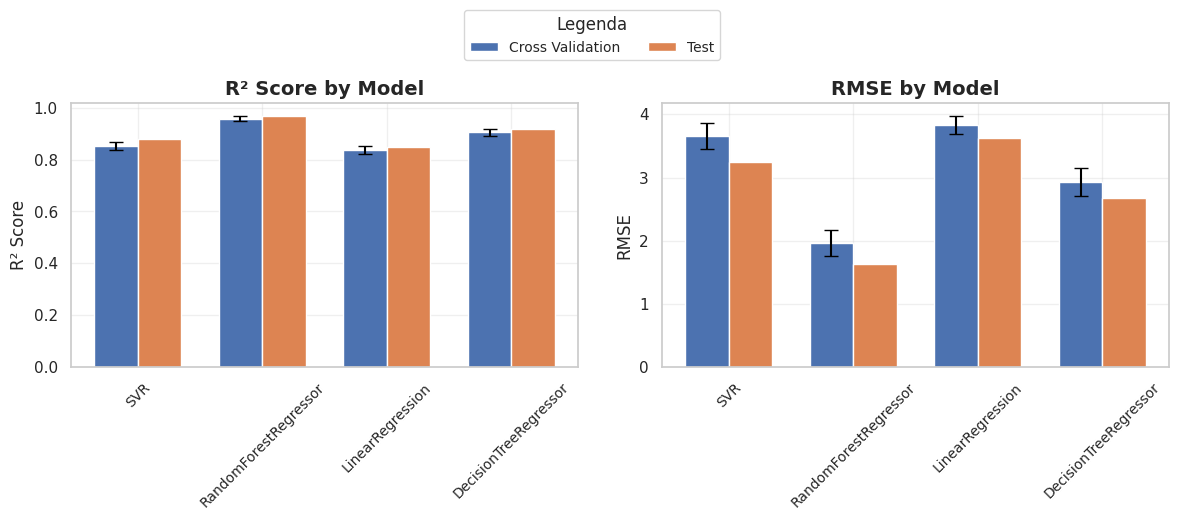

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

models = list(results.keys())
r2_cv = [results[m]['cv_r2_mean'] for m in models]
r2_cv_std = [results[m]['cv_r2_std'] for m in models]
r2_test = [results[m]['test_r2'] for m in models]
rmse_cv = [results[m]['cv_rmse_mean'] for m in models]
rmse_cv_std = [results[m]['cv_rmse_std'] for m in models]
rmse_test = [results[m]['test_rmse'] for m in models]

# Plot 1: R^2 Score
x = np.arange(len(models))
width = 0.35

bar1_r2 = ax1.bar(x - width/2, r2_cv, width, label='Cross Validation',
                  yerr=r2_cv_std, capsize=5, ecolor='black')
bar2_r2 = ax1.bar(x + width/2, r2_test, width, label='Test')
ax1.set_title('R² Score by Model', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, fontsize=10)
ax1.set_ylabel("R² Score", fontsize=12)
ax1.grid(True, alpha=0.3)

# Plot 2: RMSE
bar1_rmse = ax2.bar(x - width/2, rmse_cv, width, label='Cross Validation',
                    yerr=rmse_cv_std, capsize=5, ecolor='black')
bar2_rmse = ax2.bar(x + width/2, rmse_test, width, label='Test')
ax2.set_title('RMSE by Model', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=45, fontsize=10)
ax2.set_ylabel("RMSE", fontsize=12)
ax2.grid(True, alpha=0.3)

# Criar uma única legenda compartilhada
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, 
           title="Legenda", 
           title_fontsize=12, 
           fontsize=10, 
           loc='upper center', 
           bbox_to_anchor=(0.5, 1.05), 
           ncol=len(labels))

plt.tight_layout()
plt.subplots_adjust(top=0.85)

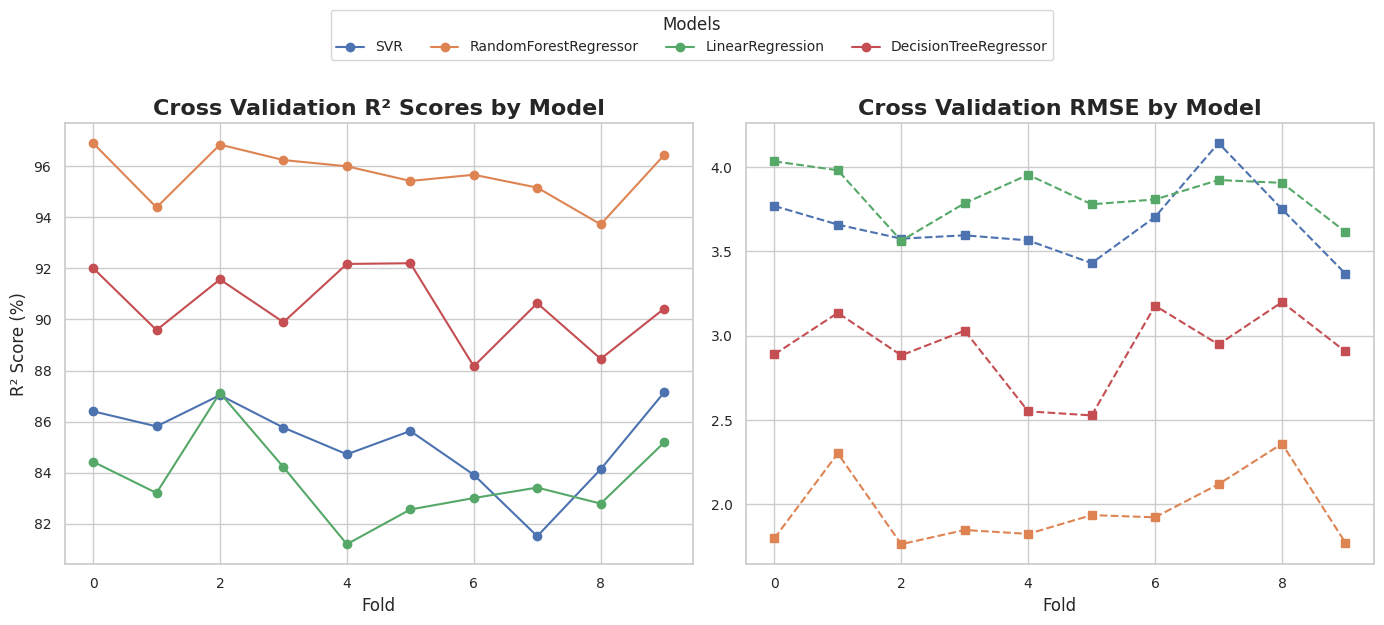

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# Gráfico de R^2
for model_name, result in results.items():
    ax1.plot(np.arange(len(result['cv_r2'])), 
             result['cv_r2'] * 100, 
             marker="o", 
             label=model_name)
ax1.set_title("Cross Validation R² Scores by Model", fontsize=16, fontweight="bold")
ax1.set_xlabel("Fold", fontsize=12)
ax1.set_ylabel("R² Score (%)", fontsize=12)
ax1.tick_params(axis="x", labelsize=10)
ax1.tick_params(axis="y", labelsize=10)

# Gráfico de RMSE
for model_name, result in results.items():
    ax2.plot(np.arange(len(result['cv_rmse'])), 
             result['cv_rmse'], 
             marker="s", 
             linestyle="--", 
             label=model_name)
ax2.set_title("Cross Validation RMSE by Model", fontsize=16, fontweight="bold")
ax2.set_xlabel("Fold", fontsize=12)
ax2.tick_params(axis="x", labelsize=10)
ax2.tick_params(axis="y", labelsize=10)

# Adicionar uma única legenda compartilhada
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, 
           title="Models", 
           title_fontsize=12, 
           fontsize=10, 
           loc='upper center', 
           bbox_to_anchor=(0.5, 1.05), 
           ncol=len(labels))

plt.tight_layout()
plt.subplots_adjust(top=0.85)

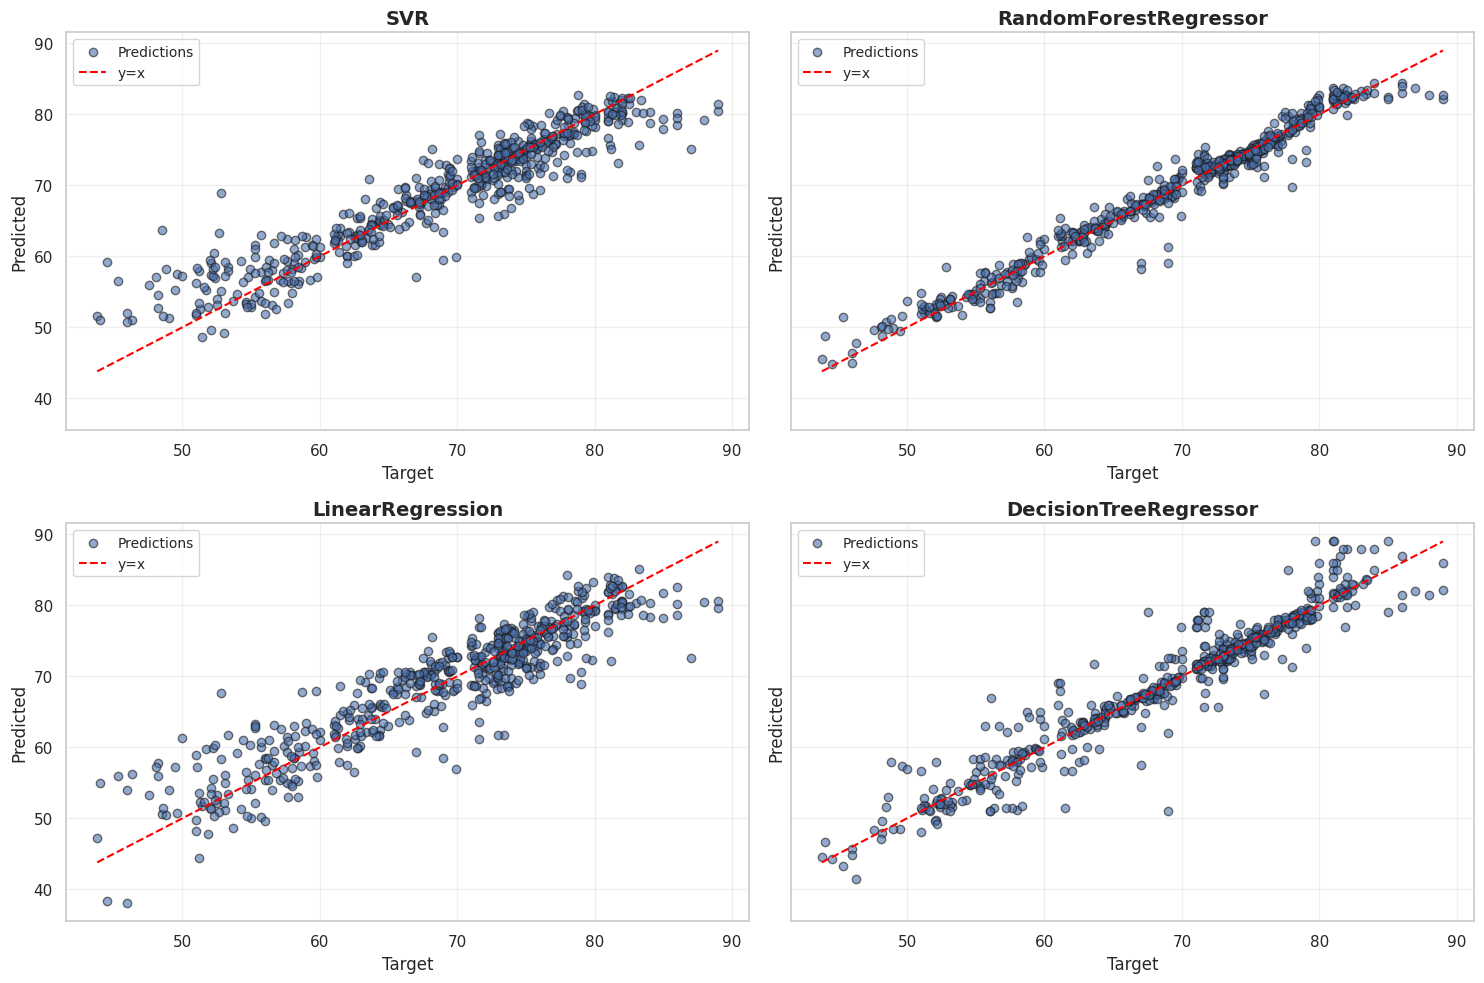

In [20]:
num_models = len(results)
cols = 2
rows = math.ceil(num_models / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), sharey=True)
axes = axes.flatten()

for ax, (model_name, result) in zip(axes, results.items()):
    y_test = result['y_test']
    y_pred = result['y_pred']
    
    ax.scatter(y_test, y_pred, alpha=0.6, edgecolor='k', label="Predictions")
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
            color='red', linestyle='--', label="y=x", linewidth=1.5)
    
    ax.set_title(model_name, fontsize=14, fontweight="bold")
    ax.set_xlabel("Target", fontsize=12)
    ax.set_ylabel("Predicted", fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)

for i in range(len(results), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()

## Best Model

In [17]:
best_model = None
best_metrics = None
best_score = float('inf')

for model_name, metrics in results.items():
    # Quanto menor o RMSE e maior o R², melhor o modelo
    # Usamos 1 - R² para ter uma métrica onde menor = melhor
    score = metrics['cv_rmse_mean'] * (1 - metrics['cv_r2_mean'])
    
    if score < best_score:
        best_score = score
        best_model = model_name
        best_metrics = {
            'CV RMSE (média)': round(metrics['cv_rmse_mean'], 4),
            'CV R² (média)': round(metrics['cv_r2_mean'], 4),
            'Test RMSE': round(metrics['test_rmse'], 4),
            'Test R²': round(metrics['test_r2'], 4)
        }

In [18]:
print(f"Best Model: {best_model}")
print("\nMetrics")
for metric, value in best_metrics.items():
    print(f"{metric}: {value}")

Best Model: RandomForestRegressor

Metrics
CV RMSE (média): 1.9647
CV R² (média): 0.9568
Test RMSE: 1.6361
Test R²: 0.9691


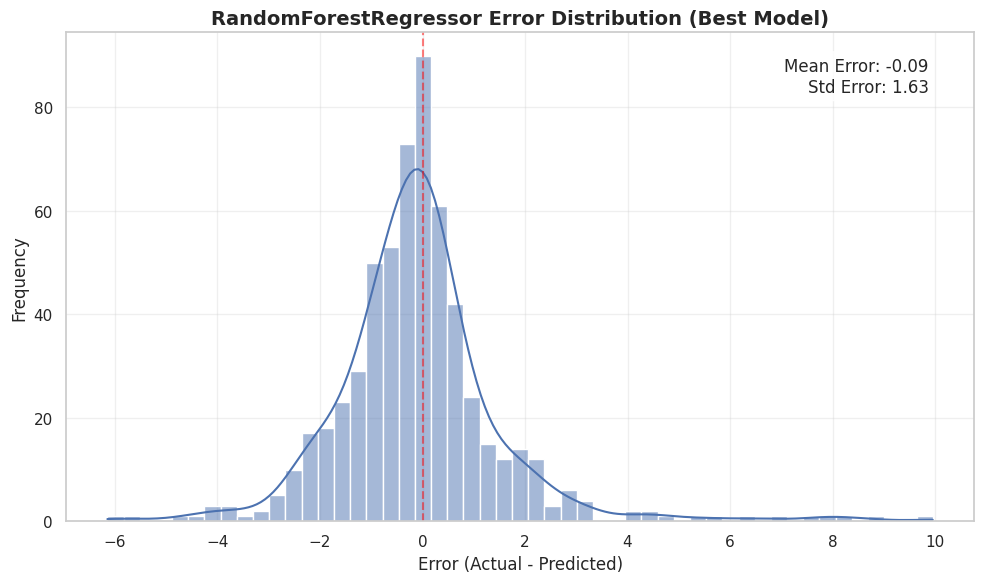

In [19]:
plt.figure(figsize=(10, 6))

errors = results[best_model]['y_test'] - results[best_model]['y_pred']

sns.histplot(errors, kde=True)

plt.axvline(x=0, color='red', linestyle='--', alpha=0.5)
plt.title(f'{best_model} Error Distribution (Best Model)', fontsize=14, fontweight='bold')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')

plt.text(0.95, 0.95, 
         f'Mean Error: {np.mean(errors):.2f}\nStd Error: {np.std(errors):.2f}',
         transform=plt.gca().transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()